# Overview

Understanding and predicting customer preferences is essential for tailoring banks' marketing efforts and driving higher customer engagement. Banks face challenges in determining the most relevant products for individual customers, especially when customer needs and preferences are influenced by numerous variables such as income, debt, loan amount, transaction history, and customer demographics. Predicting these preferences allows banks to provide personalized recommendations, improving customer satisfaction and fostering long-term relationships.

To address this challenge, we aim to develop a model that predicts individual customer preferences for banking products based on customer demographics, transaction history, and loan details. By analyzing these key factors, we can develop personalized recommendations for each customer, improving product targeting and customer experience. The model will be designed as a multi-label classification problem, where multiple products can be recommended for each customer based on their unique characteristics.

The key features influencing customer preferences include financial attributes such as income, debt, loan amount, and transaction history, as well as demographic features such as age, gender, and employment status. Transaction data provides insights into spending habits and financial priorities, while loan data gives context about a customer’s current and future financial commitments. Additionally, we will incorporate the results from customer segmentation to fine-tune the model’s predictions for specific customer groups. By leveraging customer segments as an additional feature, we can ensure that the recommendations are tailored to each segment's specific needs and behaviors.

Outline:
1. **Data Preprocessing**:
   - Aggregate the transaction data (transactions.csv) to summarise transaction behaviour per customer. This will include:
     - Average transaction amount
     - Transaction count/frequency
   - Aggregate the loan data (loans.csv) per customer. This will include:
      - Has active loans
      - Total loan amount
      - Number of loans
      - Average loan amount
   - Merge customer.csv the aggregated transactions and loans data using `customer_id` as the shared column.

2. **Exploratory Data Analysis (EDA)**:
   - Perform initial data exploration to understand distributions, correlations, and relationships between customer attributes (e.g., income, age, debt) and product preferences.
   - Visualize trends in aggregated transaction data (e.g., total spending, frequency) and loan data (e.g., loan amounts, loan types) to identify potential patterns that could indicate product interest.
   - Detect any outliers, anomalies, or biases that could negatively affect model performance.

3. **Feature Engineering**:
   - kiv, see whether need to scale or whether need new features (esp ratios bet financial attributes)
   - Include the customer segmentation results as an additional categorical feature

4. **Modeling**:
   - Since this is a multi-label classification problem, I will likely be using algorithms such as Random Forest or XGBoost

By developing this predictive model, the bank will be able to better understand customer preferences, allowing for personalized product recommendations, improved targeting of marketing campaigns, and more efficient allocation of resources. This will enable the bank to optimize marketing efforts by focusing on products most likely to meet individual customer needs, increase cross-selling opportunities, enhance customer loyalty, and ultimately drive a higher return on investment in marketing campaigns.



# Data Preprocessing

## Loading the data

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

project_root = os.getcwd()  
# Path to the processed data folder
path = os.path.join(project_root, "..", "..", "data", "processed")

# Load the CSV files
customer_df = pd.read_csv(os.path.join(path, "customer.csv"))
transactions_df = pd.read_csv(os.path.join(path, "transactions.csv"))
loans_df = pd.read_csv(os.path.join(path, "loans.csv"))
products_df = pd.read_csv(os.path.join(path, "products_owned.csv"))
customer_segments = pd.read_csv("../../customer_segmentation/customer_segments.csv")


## Data cleaning 

In [91]:
# Converting date features to datetime
transactions_df["transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
loans_df["due_date"] = pd.to_datetime(loans_df["due_date"])
loans_df["paid_off_date"] = pd.to_datetime(loans_df["paid_off_date"])

# Creating binary feature for loan status
loans_df["is_paid_off"] = loans_df["paid_off_date"].notna().astype(int)

transactions_df
#loans_df.head()

,transaction_id,customer_id,transaction_type,transaction_amt,transaction_date
0,539007,3756,Deposit,227.14,2023-12-18 13:20:37
1,156244,3756,Transfer,335.07,2023-10-01 07:57:52
2,681254,3756,Transfer,387.22,2023-09-24 16:31:33
3,844971,2633,Credit,273.43,2023-03-12 23:57:53
4,395194,3705,Credit,880.78,2024-08-04 09:54:47
...,...,...,...,...,...
5346,909639,2647,Deposit,213.05,2024-06-19 22:54:49
5347,571349,2647,Credit,561.53,2024-05-27 19:59:35
5348,371644,2647,Transfer,308.61,2023-06-06 08:56:04
5349,725617,1639,Transfer,223.10,2023-08-06 13:20:04


## Data Aggregation

### Transactions table

In [92]:
# Aggregating the data per customer_id
aggregated_transactions = transactions_df.groupby('customer_id').agg(
    avg_transaction_amt=('transaction_amt', 'mean'),  # Average transaction amount
    transaction_count=('transaction_id', 'count')     # Count of transactions (frequency)
).reset_index()

# Calculate the number of unique months per customer
transactions_df['year_month'] = transactions_df['transaction_date'].dt.to_period('M')

# Group by customer_id to get the count of unique months
unique_months = transactions_df.groupby('customer_id')['year_month'].nunique().reset_index(name='unique_month_count')

# Merge the results together
aggregated_transactions = pd.merge(aggregated_transactions, unique_months, on='customer_id', how='left')

# Calculate the average transactions per month
aggregated_transactions['avg_transactions_per_month'] = aggregated_transactions['transaction_count'] / aggregated_transactions['unique_month_count']

aggregated_transactions = aggregated_transactions[['customer_id', 'avg_transaction_amt', 'transaction_count', 'avg_transactions_per_month']]
aggregated_transactions

,customer_id,avg_transaction_amt,transaction_count,avg_transactions_per_month
0,1,115.292500,4,1.0
1,2,88.040000,2,1.0
2,3,121.390000,1,1.0
3,5,38.780000,1,1.0
4,9,86.540000,1,1.0
...,...,...,...,...
1848,3991,851.668571,7,1.0
1849,3993,290.378000,5,1.0
1850,3996,429.280000,3,1.0
1851,3997,261.880000,1,1.0


### Loans table


In [93]:
from datetime import datetime

# Convert relevant columns to datetime
loans_df['due_date'] = pd.to_datetime(loans_df['due_date'])
loans_df['paid_off_date'] = pd.to_datetime(loans_df['paid_off_date'], errors='coerce')

# 1. Has active loans
loans_df['has_active_loan'] = loans_df['paid_off_date'].isnull()

# 2. Total loan amount
total_loan_amount = loans_df.groupby('customer_id')['loan_amount'].sum().reset_index(name='total_loan_amount')

# 3. Number of loans
num_loans = loans_df.groupby('customer_id')['loan_id'].count().reset_index(name='num_loans')

# 4. Average loan amount
avg_loan_amount = loans_df.groupby('customer_id')['loan_amount'].mean().reset_index(name='avg_loan_amount')

# 5. Aggregate has active loans
active_loans = loans_df.groupby('customer_id')['has_active_loan'].max().reset_index(name='has_active_loans')

# Merge all aggregated data
loan_aggregates = total_loan_amount.merge(num_loans, on='customer_id') \
                                   .merge(avg_loan_amount, on='customer_id') \
                                   .merge(active_loans, on='customer_id') 
# Display the result
loan_aggregates
#loan_aggregates.describe()


,customer_id,total_loan_amount,num_loans,avg_loan_amount,has_active_loans
0,1,21625.0,3,7208.333333,False
1,2,63175.0,3,21058.333333,True
2,3,81575.0,3,27191.666667,False
3,4,27300.0,3,9100.000000,False
4,7,25000.0,3,8333.333333,True
...,...,...,...,...,...
2624,3995,36300.0,3,12100.000000,False
2625,3996,26000.0,3,8666.666667,False
2626,3997,56850.0,3,18950.000000,True
2627,3999,15800.0,3,5266.666667,True


### Final table

In [102]:
# Select relevant rows from customers_df
customer_df = customer_df[['customer_id', 'age', 'job', 'marital', 'education', 'default', 'balance', 'debt', 'income', 'dependents']]

# Merge customer_df with loan_aggregates
merged_data = pd.merge(customer_df, loan_aggregates, on="customer_id", how="left")

# Merge the result with aggregated_transactions
merged_data = pd.merge(merged_data, aggregated_transactions, on="customer_id", how="left")

# Merge the result with customer_segments
merged_data = pd.merge(merged_data, customer_segments, on="customer_id", how="left")

# Merge the result with products_df
merged_data = pd.merge(merged_data, products_df, on="customer_id", how="left")

# Check the merged data
df = merged_data
df

,customer_id,age,job,marital,education,default,balance,debt,income,dependents,...,avg_transaction_amt,transaction_count,avg_transactions_per_month,Segment,has_investment_product,has_credit_card,has_home_loan,has_personal_loan,has_fixed_deposit,has_insurance
0,496,47,unemployed,single,secondary,1,-23782.71,18829.82,228.34,3,...,87.680000,1.0,1.0,At risk / inactive customers,1,0,0,1,0,0
1,540,32,unemployed,single,primary,1,-7812.19,5838.78,140.17,1,...,146.830000,2.0,1.0,Budget-conscious,0,0,0,0,0,0
2,244,32,unemployed,single,tertiary,1,-7725.79,25796.13,454.52,2,...,251.260000,1.0,1.0,Budget-conscious,0,1,0,0,1,0
3,286,35,unemployed,married,secondary,1,-6873.81,5796.03,1292.46,2,...,110.205000,2.0,1.0,Budget-conscious,0,1,0,0,0,0
4,311,27,student,married,tertiary,1,-6695.05,5394.01,661.52,5,...,NaN,NaN,NaN,At risk / inactive customers,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2529,34,unknown,single,secondary,0,97024.13,39854.34,25046.87,3,...,NaN,NaN,NaN,At risk / inactive customers,0,1,0,1,0,1
3996,1574,37,unknown,married,secondary,0,163709.21,7606.30,25955.90,0,...,175.245000,2.0,1.0,Budget-conscious,0,1,0,0,1,1
3997,3039,61,unknown,single,primary,0,212586.13,99705.63,26263.01,3,...,1401.393333,9.0,1.0,High-value,0,1,0,1,0,0
3998,910,55,unknown,married,primary,0,265872.80,11444.15,27211.16,2,...,NaN,NaN,NaN,At risk / inactive customers,1,0,0,0,1,0


## Exploratory Data Analysis

In [95]:
# Summary statistics for numerical features
df.describe()


,customer_id,age,default,balance,debt,income,dependents,total_loan_amount,num_loans,avg_loan_amount,avg_transaction_amt,transaction_count,avg_transactions_per_month,has_investment_product,has_credit_card,has_home_loan,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,2629.000000,2629.000000,2629.000000,1853.000000,1853.000000,1853.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,40.106000,0.161250,1875.393955,25815.447313,4959.743832,2.342750,37635.051350,3.012552,12504.211043,382.602610,2.887750,1.052878,0.250750,0.700750,0.033750,0.281750,0.206250,0.314250
std,1154.844867,10.525966,0.367807,9880.971068,25329.882697,3225.706975,1.302765,13858.590592,0.193684,4495.497588,309.174719,2.044939,0.164453,0.433499,0.457987,0.180608,0.449908,0.404663,0.464275
min,1.000000,18.000000,0.000000,-23782.710000,1228.020000,140.170000,0.000000,7000.000000,3.000000,2333.333333,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,0.000000,63.697500,10262.420000,2768.522500,1.000000,27600.000000,3.000000,9250.000000,178.200000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,40.000000,0.000000,368.460000,17888.280000,4149.510000,2.000000,36300.000000,3.000000,12091.666667,300.160000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3000.250000,47.000000,0.000000,1337.090000,32302.307500,6200.332500,3.000000,46600.000000,3.000000,15500.000000,492.500000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,4000.000000,77.000000,1.000000,402108.010000,300575.210000,28807.410000,5.000000,120625.000000,6.000000,32500.000000,3599.850000,16.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The features num_loans, avg_loan_amount, transaction_count, avg_transaction_amt, and avg_transactions_per_month exhibit a significant amount of missing data. We will first assess their correlation with the target variables before deciding whether to drop these features or impute the missing values.

Furthermore, the features balance and debt contain extreme values, indicating the presence of outliers. To mitigate the risk of overfitting, we will consider capping or trimming these extreme values. Additionally, both balance and debt display a right-skewed distribution (i.e., mean > median). This skewness could lead to uneven splits in tree-based models. To improve model interpretability and performance, we will apply a log transformation to these features.

In [80]:
# Capping Extreme Values
# Define a function to cap values at the 1st and 99th percentiles
def cap_outliers(df, col_name):
    lower_percentile = df[col_name].quantile(0.01)  # 1st percentile
    upper_percentile = df[col_name].quantile(0.99)  # 99th percentile
    
    df[col_name] = df[col_name].clip(lower=lower_percentile, upper=upper_percentile)
    
# Apply to 'balance' and 'debt'
cap_outliers(df, 'balance')
cap_outliers(df, 'debt')

# Apply Log Transformation to Skewed Features
# To avoid issues with negative values or zero, we shift the values by a constant before applying log
def log_transform(df, col_name):
    # Apply log transformation while avoiding log(0) or log(negative) by adding a constant
    df[col_name] = np.log1p(df[col_name])  # np.log1p does log(1 + x), which handles zeros well

# Apply log transformation to 'balance' and 'debt' (if they are positively skewed)
log_transform(df, 'balance')
log_transform(df, 'debt')

# Check the transformed values
df[['balance', 'debt']].describe()


c:\Users\sybel\dsa3101-bank-marketing-group-1\.venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,balance,debt
count,3355.000000,4000.000000
mean,6.300955,9.805008
std,1.654275,0.830286
min,1.101940,7.842235
25%,5.213221,9.236341
50%,6.312732,9.791957
75%,7.421584,10.382925
max,10.083754,11.762218


### Transactions vs product ownership
Visualise the relationships between avg_transaction_amt and transaction_count with each product

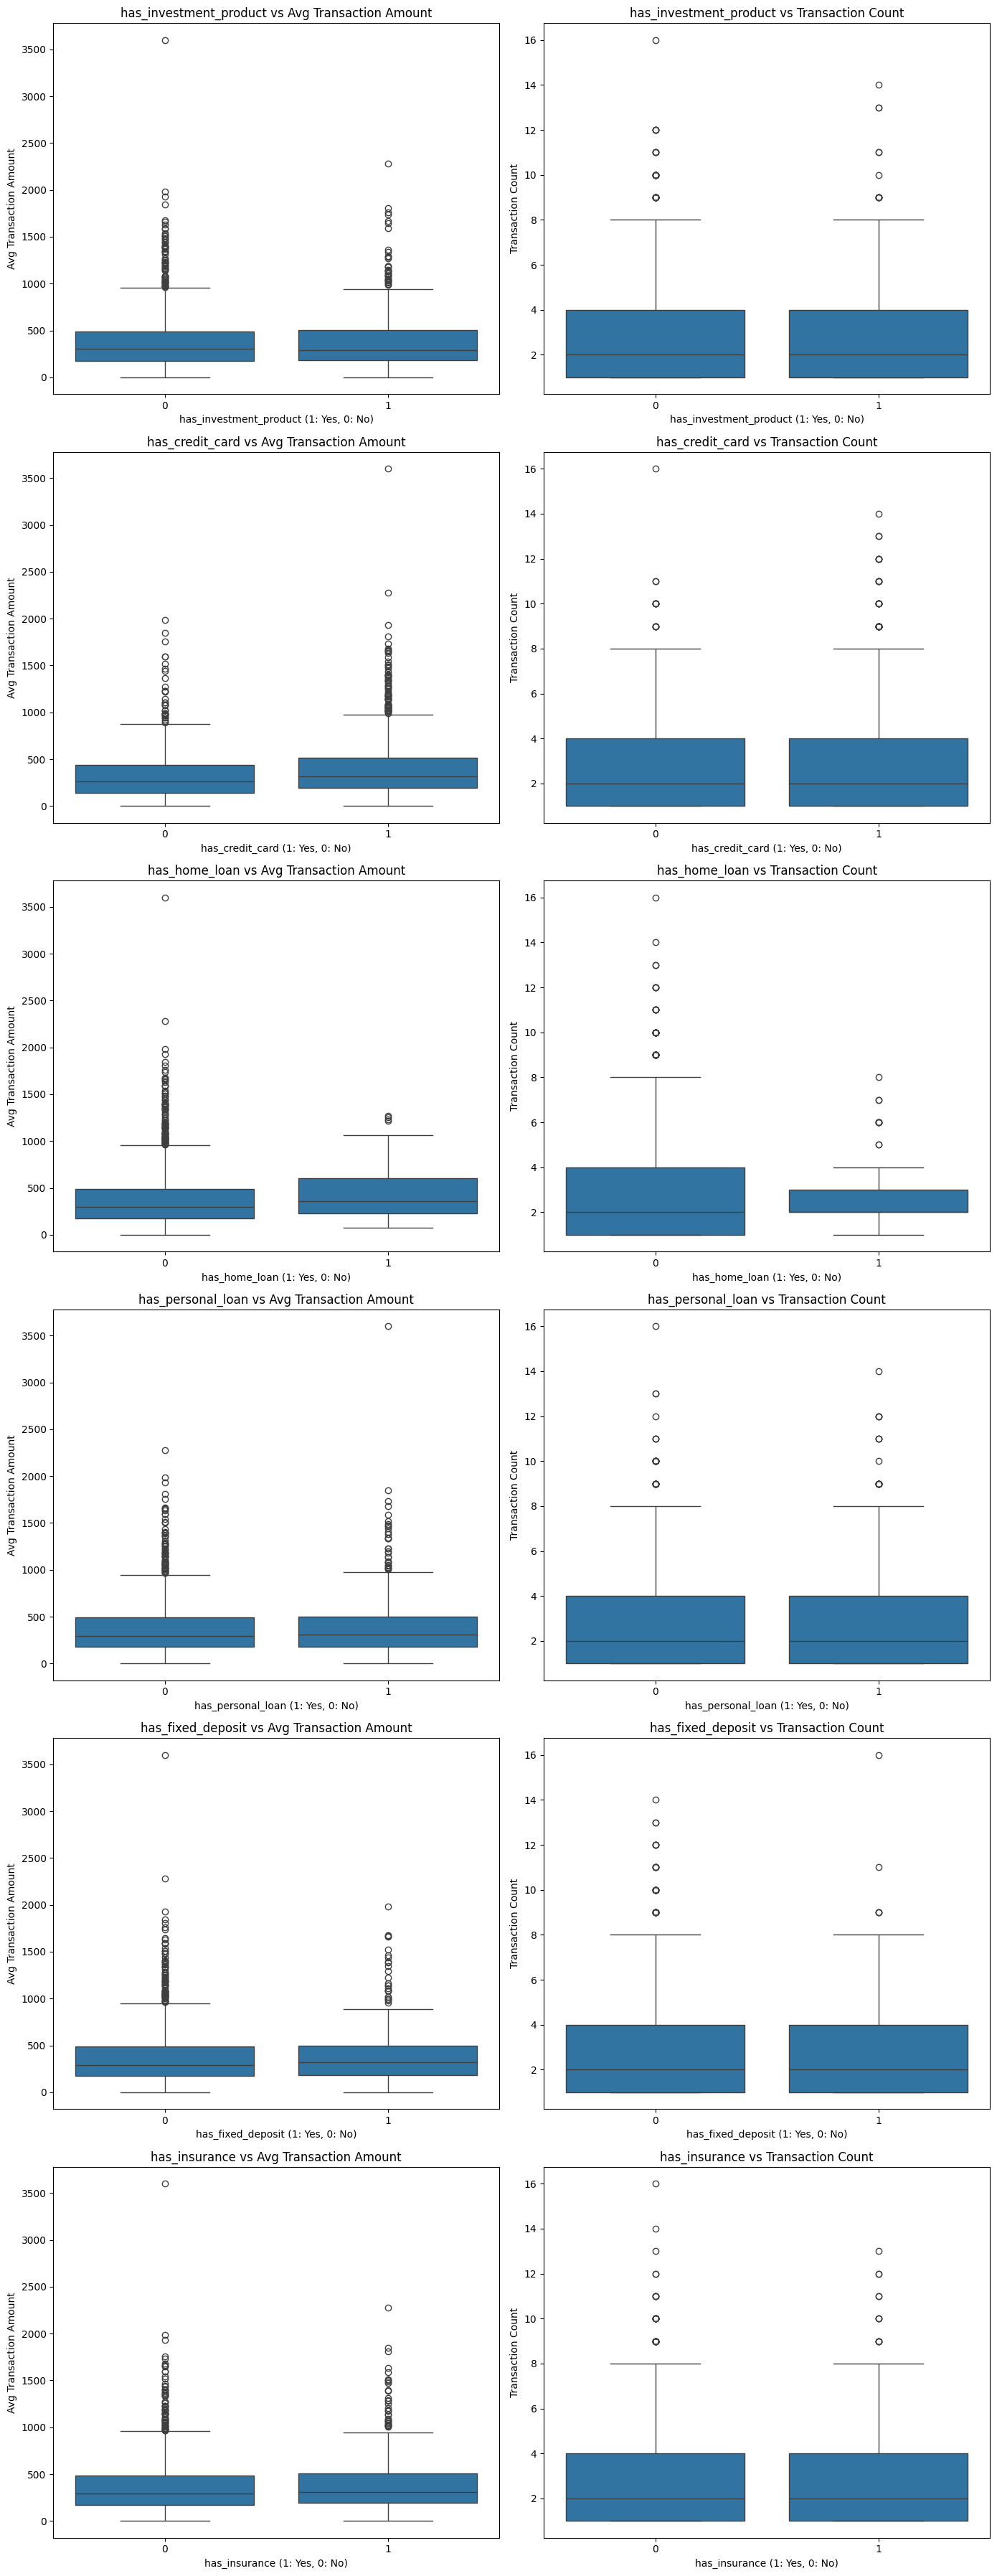

In [96]:
# List of product ownership columns
product_columns = [
    "has_investment_product", "has_credit_card", "has_home_loan",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

# Plot relationships for each product ownership
fig, axes = plt.subplots(len(product_columns), 2, figsize=(14, 6 * len(product_columns)))

for i, product in enumerate(product_columns):
    # Plot the relationship between product ownership and avg_transaction_amt
    sns.boxplot(x=product, y='avg_transaction_amt', data=merged_data, ax=axes[i, 0])
    axes[i, 0].set_title(f'{product} vs Avg Transaction Amount')
    axes[i, 0].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 0].set_ylabel('Avg Transaction Amount')
    
    # Plot the relationship between product ownership and transaction_count
    sns.boxplot(x=product, y='transaction_count', data=merged_data, ax=axes[i, 1])
    axes[i, 1].set_title(f'{product} vs Transaction Count')
    axes[i, 1].set_xlabel(f'{product} (1: Yes, 0: No)')
    axes[i, 1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()


Moreover, the box plots indicate that the available transaction data does not show a significant impact on whether a customer owns any of the products, hence we will exclude it from the modeling process.

### Loans vs product ownership
Visualise the relationships between each aggregated loan feature with each product

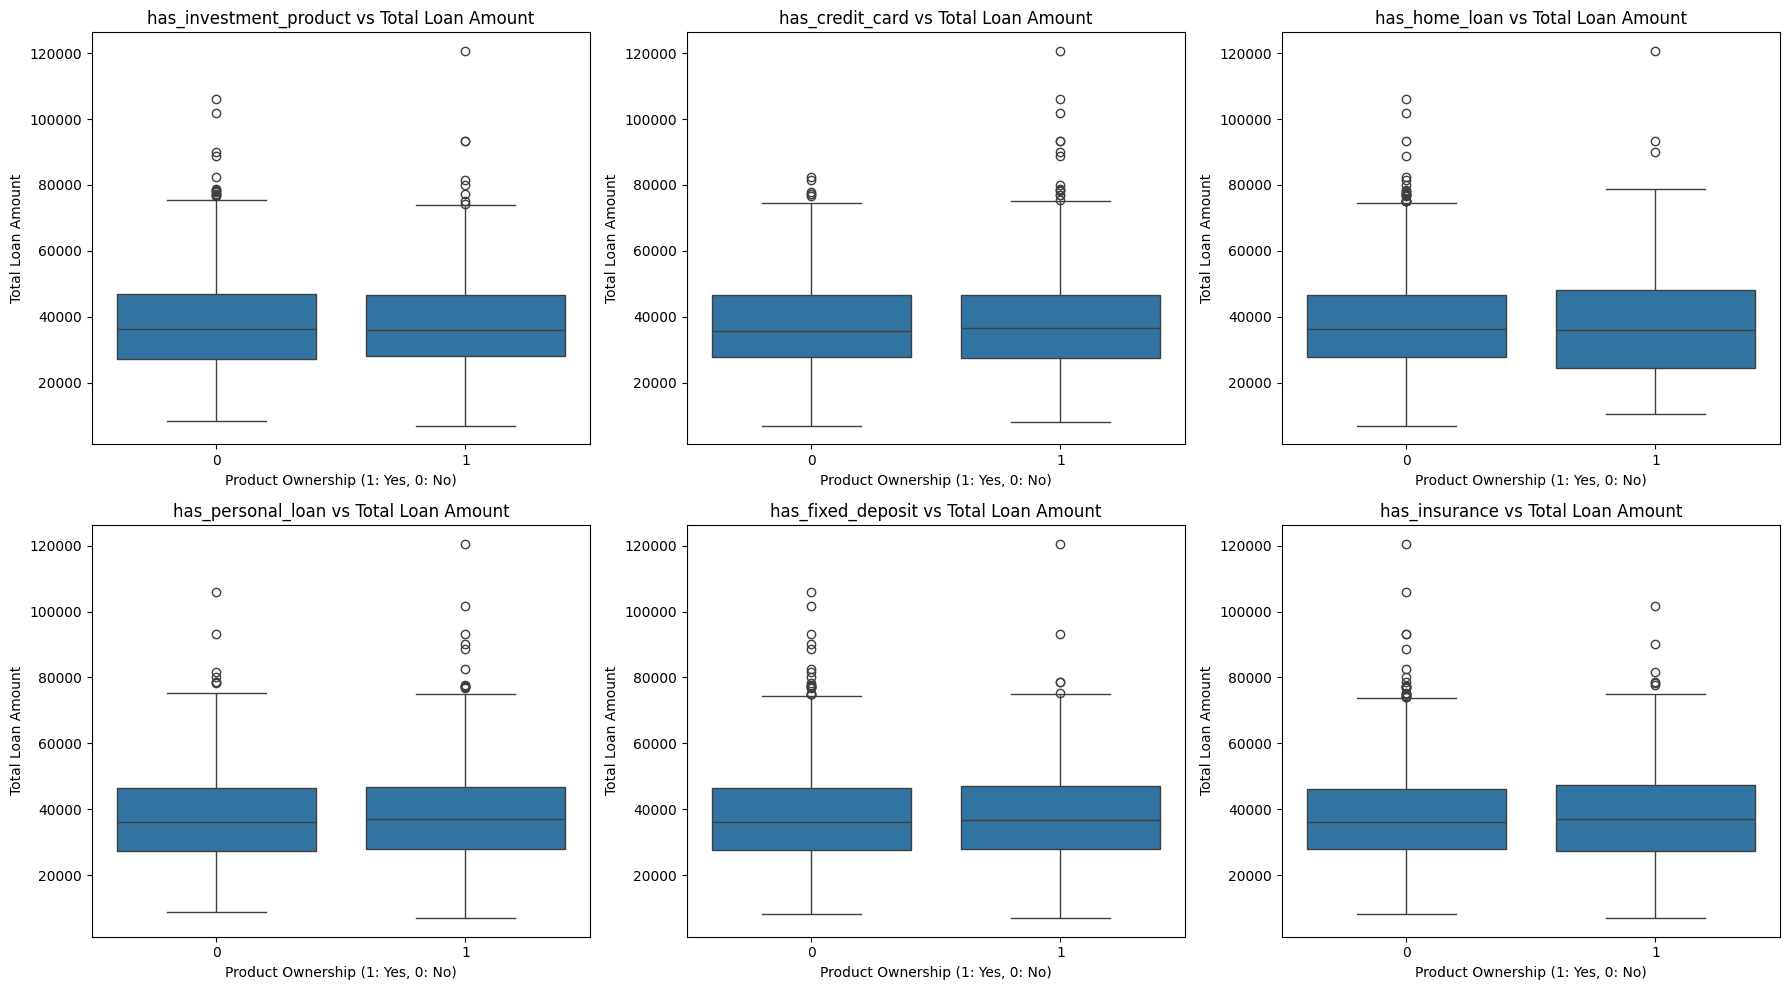

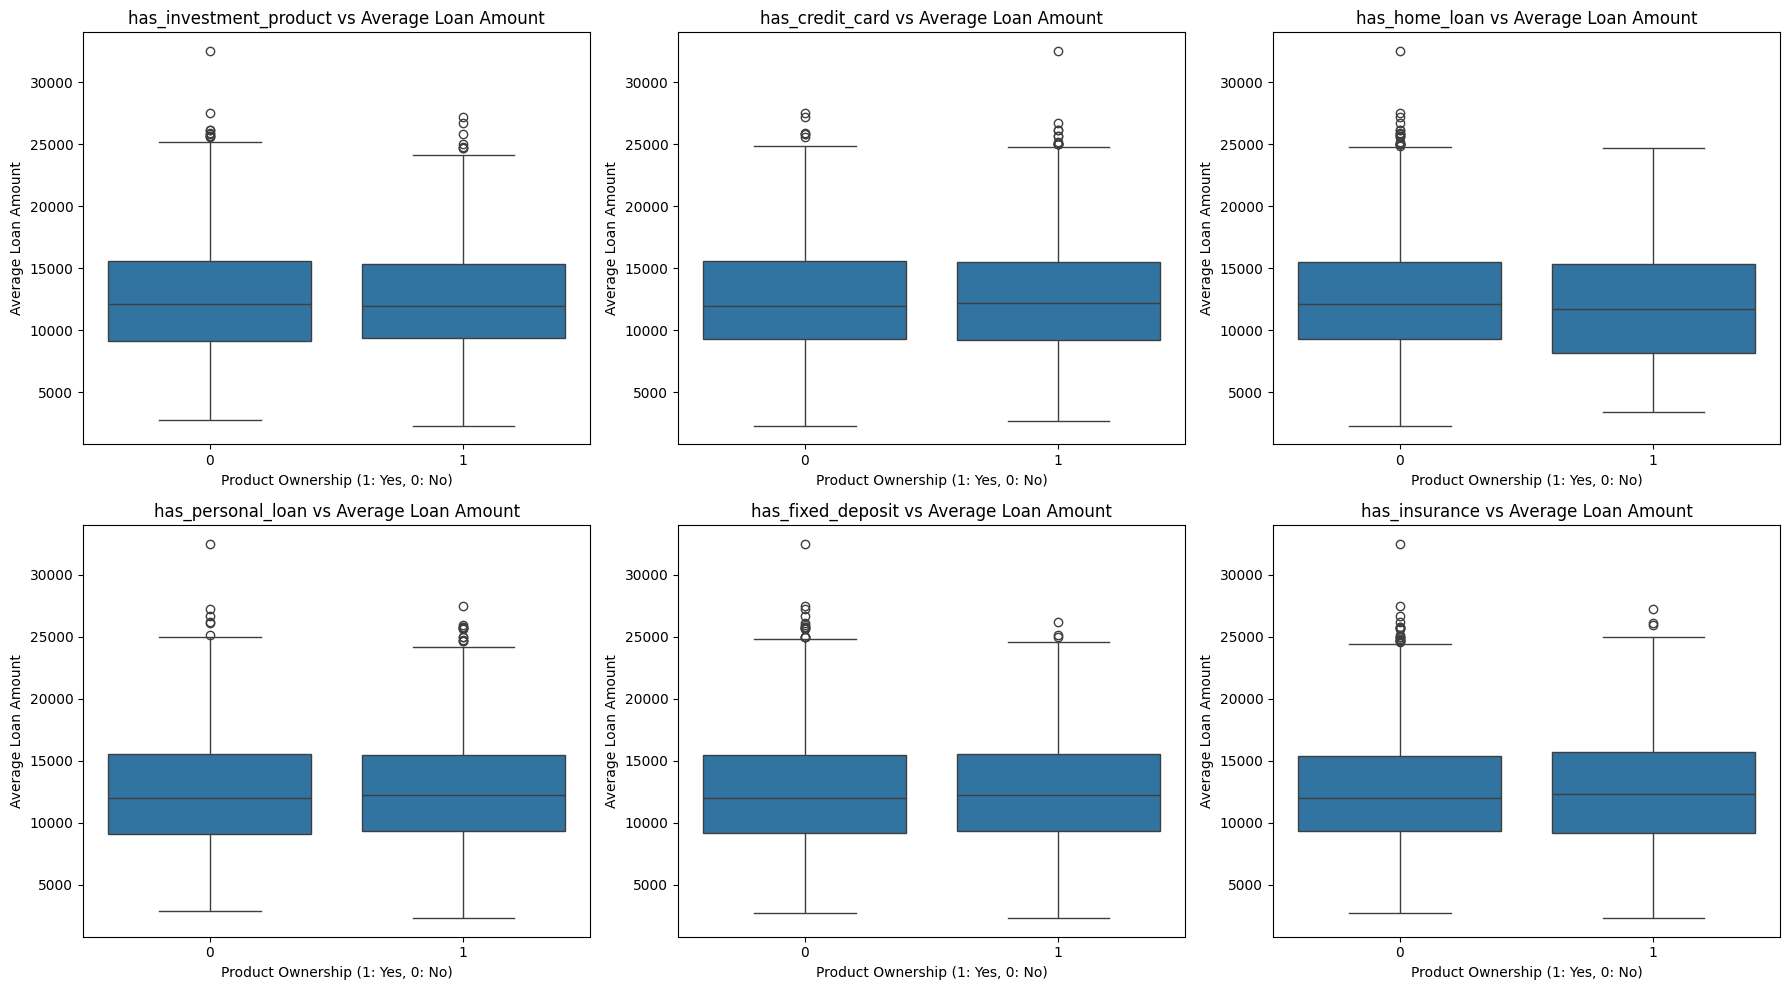

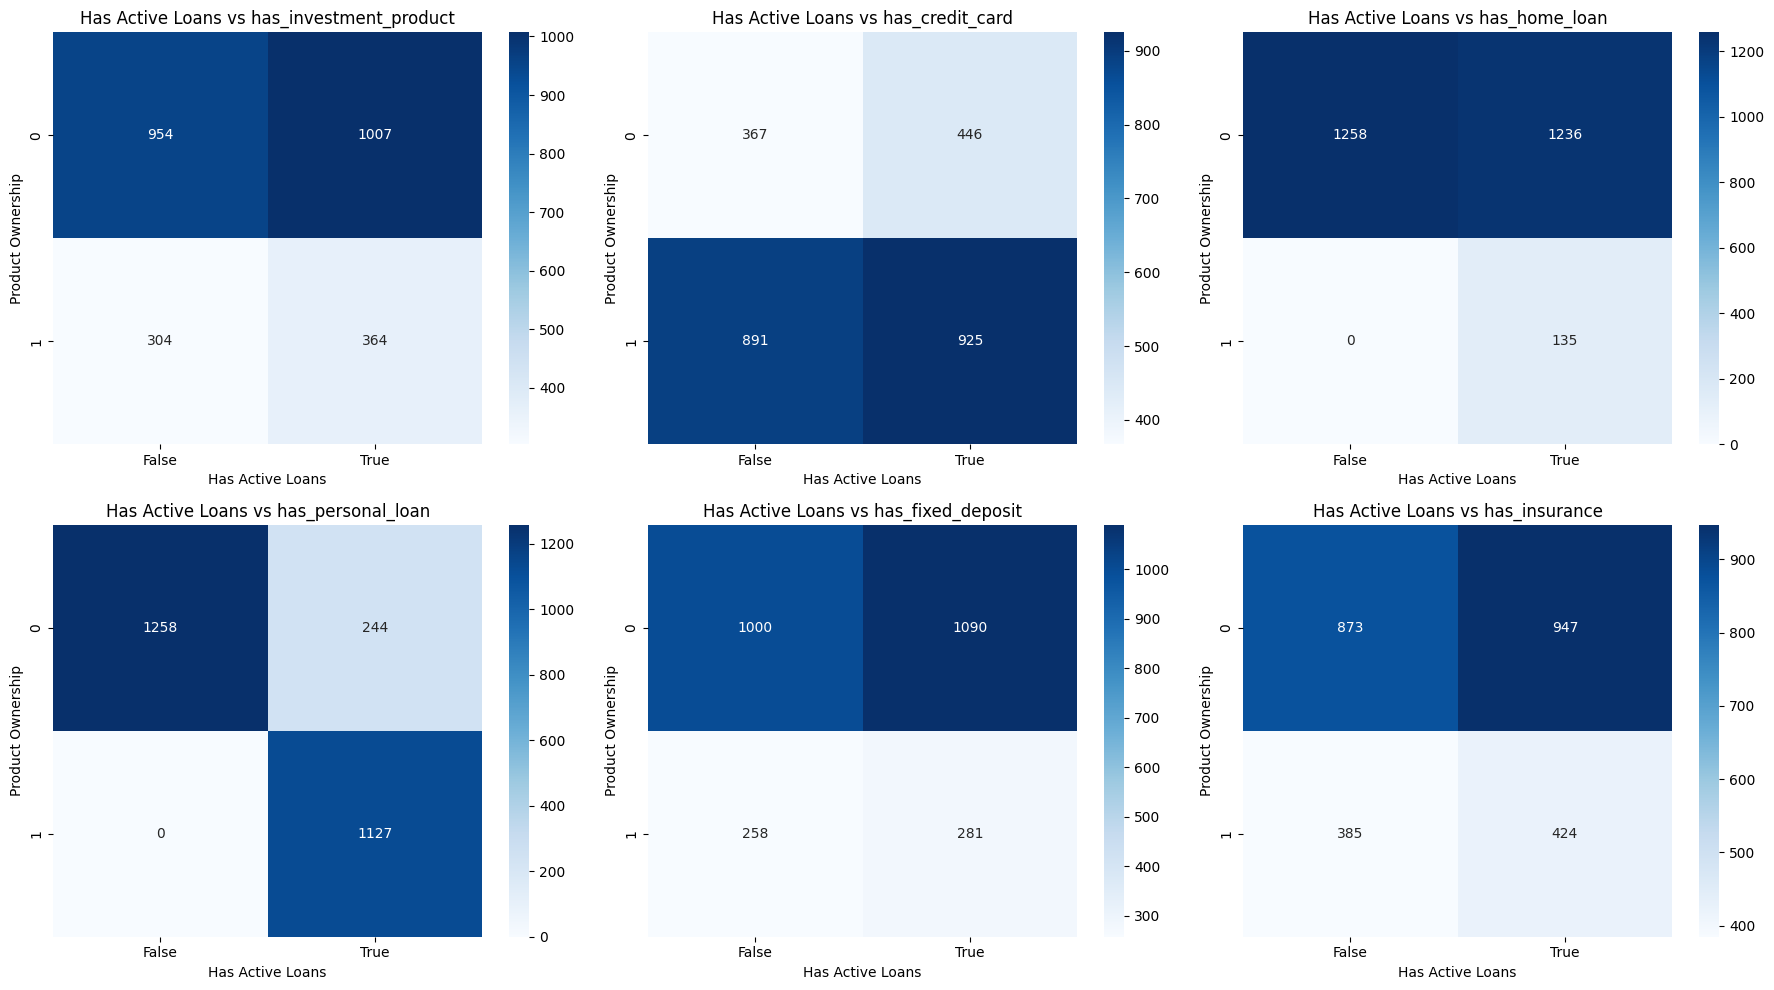

<Figure size 640x480 with 0 Axes>

In [97]:
# 1. Boxplot for Total Loan Amount and Average Loan Amount for Each Product Ownership
product_columns = [
    'has_investment_product', 
    'has_credit_card', 
    'has_home_loan', 
    'has_personal_loan', 
    'has_fixed_deposit', 
    'has_insurance'
]

# Set up the plot for boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot total loan amount vs product ownership
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    sns.boxplot(x=merged_data[product_col], y=merged_data['total_loan_amount'], ax=axes[row, col])
    axes[row, col].set_title(f'{product_col} vs Total Loan Amount')
    axes[row, col].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[row, col].set_ylabel('Total Loan Amount')

# Adjust layout
plt.tight_layout()
plt.show()

# Set up the plot for average loan amount boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot average loan amount vs product ownership
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    sns.boxplot(x=merged_data[product_col], y=merged_data['avg_loan_amount'], ax=axes[row, col])
    axes[row, col].set_title(f'{product_col} vs Average Loan Amount')
    axes[row, col].set_xlabel('Product Ownership (1: Yes, 0: No)')
    axes[row, col].set_ylabel('Average Loan Amount')

# Adjust layout
plt.tight_layout()
plt.show()


# 2. Heatmap for has_active_loans vs Product Ownership

# Create a contingency table for has_active_loans vs each product ownership
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, product_col in enumerate(product_columns):
    row, col = divmod(i, 3)
    contingency_table_active = pd.crosstab(merged_data[product_col], merged_data['has_active_loans'])
    sns.heatmap(contingency_table_active, annot=True, cmap="Blues", fmt="d", ax=axes[row, col])
    axes[row, col].set_title(f'Has Active Loans vs {product_col}')
    axes[row, col].set_xlabel('Has Active Loans')
    axes[row, col].set_ylabel('Product Ownership')

# Adjust layout
plt.tight_layout()
plt.show()


# Adjust layout
plt.tight_layout()
plt.show()



Features total_loan_amt and avg_loan_amt do not show a significant impact on whether a customer owns any of the products, hence we will exclude it from the modeling process. We will keep has_active_loans, which appears to be strongly correlated with each products' ownership.

### Categorical Feature Distributions

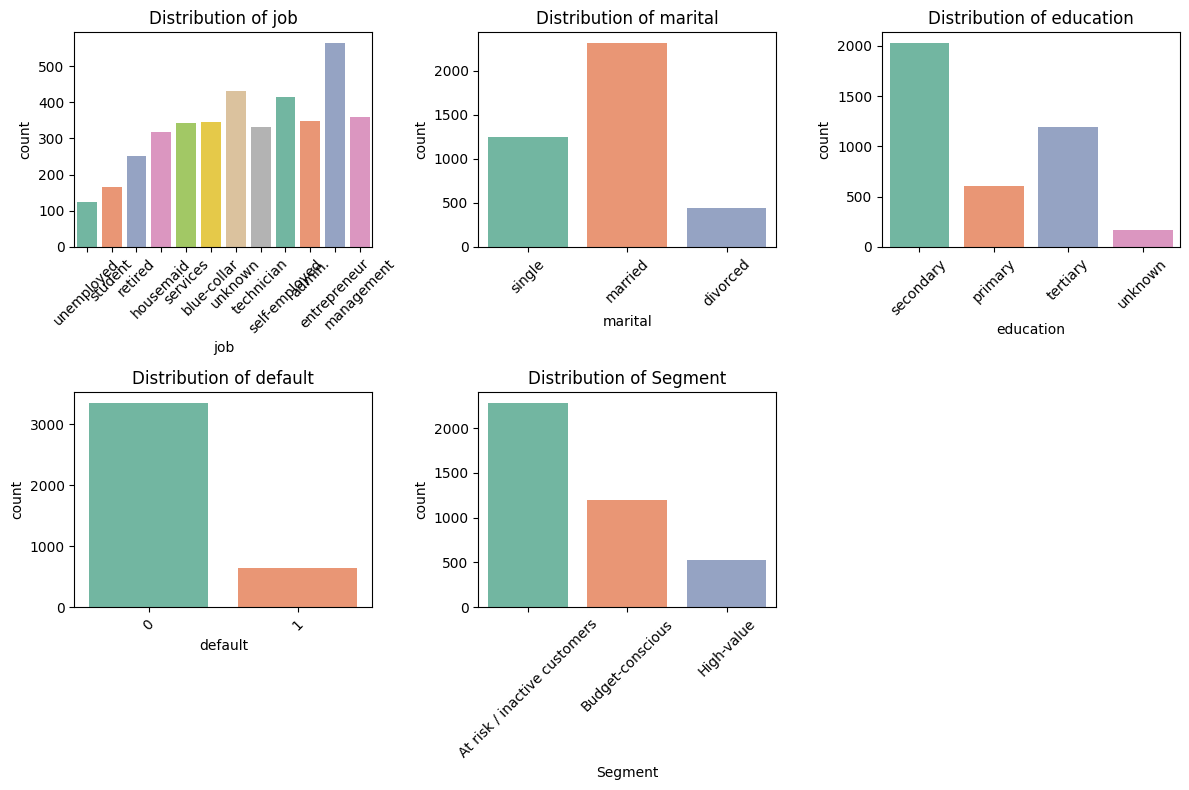

In [98]:
# List of categorical features to analyze
categorical_features = ['job', 'marital', 'education', 'default', 'Segment']

# Plot the distributions of categorical features using bar plots
plt.figure(figsize=(12, 8))

# Loop through each categorical feature to plot
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)  # Adjust number of rows and columns based on your data
    sns.countplot(x=feature, hue=feature, data=df, palette="Set2", legend=False)
    plt.title(f'Distribution of {feature}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


The default feature exhibits significant class imbalance, with the majority of customers classified as non-default. To assess whether this feature holds predictive value for customer product preferences, we will check its correlation with the target variables.

In [99]:
# Check correlation between `default` and other target variables
target_columns = ['has_investment_product', 'has_credit_card', 'has_home_loan', 'has_personal_loan', 'has_fixed_deposit', 'has_insurance']
correlations = df[target_columns].apply(lambda x: x.corr(df['default']))

print(correlations)


has_investment_product   -0.010561
has_credit_card          -0.155847
has_home_loan            -0.021716
has_personal_loan         0.007966
has_fixed_deposit        -0.025254
has_insurance            -0.106448
dtype: float64


Given that the correlations are very weak and close to zero, it appears that the default feature does not significantly contribute to predicting product ownership. As a result, we decided to drop this feature from the model.

### Dropping features

In [104]:
df = df.drop(columns=['default', 'num_loans', 'total_loan_amount', 'avg_loan_amount', 'transaction_count', 'avg_transaction_amt', 'avg_transactions_per_month'])

df

,customer_id,age,job,marital,education,balance,debt,income,dependents,has_active_loans,Segment,has_investment_product,has_credit_card,has_home_loan,has_personal_loan,has_fixed_deposit,has_insurance
0,496,47,unemployed,single,secondary,-23782.71,18829.82,228.34,3,True,At risk / inactive customers,1,0,0,1,0,0
1,540,32,unemployed,single,primary,-7812.19,5838.78,140.17,1,False,Budget-conscious,0,0,0,0,0,0
2,244,32,unemployed,single,tertiary,-7725.79,25796.13,454.52,2,False,Budget-conscious,0,1,0,0,1,0
3,286,35,unemployed,married,secondary,-6873.81,5796.03,1292.46,2,NaN,Budget-conscious,0,1,0,0,0,0
4,311,27,student,married,tertiary,-6695.05,5394.01,661.52,5,False,At risk / inactive customers,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2529,34,unknown,single,secondary,97024.13,39854.34,25046.87,3,True,At risk / inactive customers,0,1,0,1,0,1
3996,1574,37,unknown,married,secondary,163709.21,7606.30,25955.90,0,False,Budget-conscious,0,1,0,0,1,1
3997,3039,61,unknown,single,primary,212586.13,99705.63,26263.01,3,True,High-value,0,1,0,1,0,0
3998,910,55,unknown,married,primary,265872.80,11444.15,27211.16,2,NaN,At risk / inactive customers,1,0,0,0,1,0


### Explore product ownership

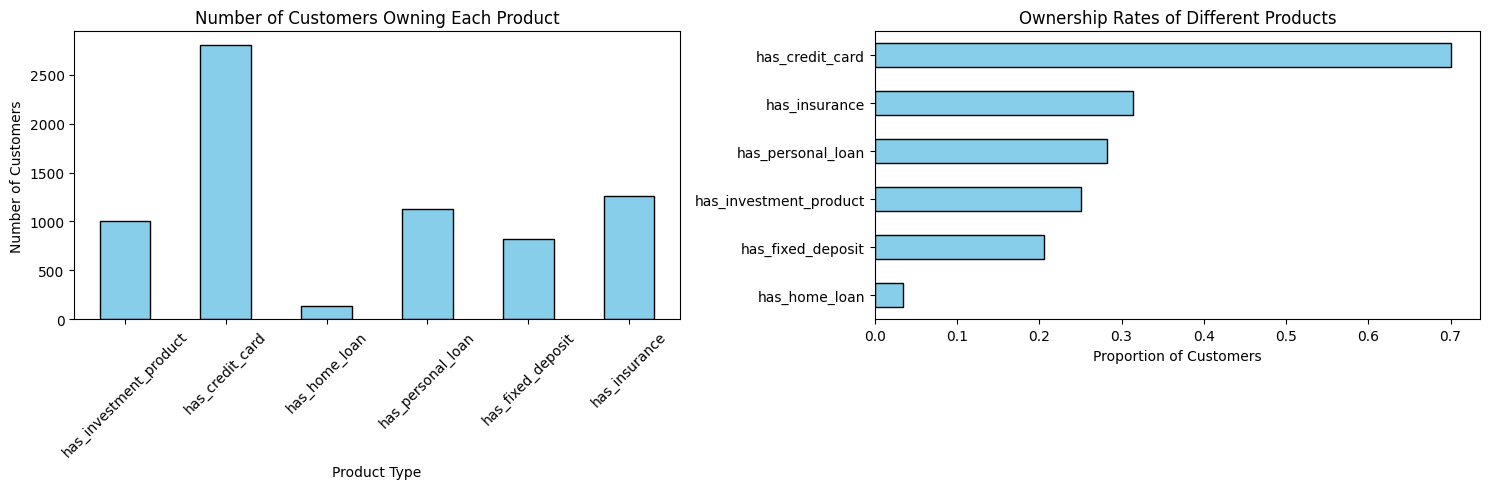

In [86]:
#count customers who have each product
product_counts = products_df.drop(columns=["customer_id"]).sum()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Number of customers owning each product
product_counts.plot(kind="bar", color="skyblue", edgecolor="black", ax=axes[0])
axes[0].set_title("Number of Customers Owning Each Product")
axes[0].set_xlabel("Product Type")
axes[0].set_ylabel("Number of Customers")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Ownership rates of different products
products_df.drop(columns="customer_id").mean().sort_values().plot(kind="barh", ax=axes[1], color="skyblue", edgecolor="black")
axes[1].set_title("Ownership Rates of Different Products")
axes[1].set_xlabel("Proportion of Customers")

# Show the plots
plt.tight_layout()
plt.show()


Given the high imbalance in the distribution of product ownership, we will employ tree-based models, such as Random Forest and XGBoost, for our product recommendation system. These models are well-suited to handle class imbalance, as they are less sensitive to skewed class distributions and can effectively capture complex patterns in the data.

## Baseline model

In [110]:
df.describe()

,customer_id,age,balance,debt,income,dependents,has_investment_product,has_credit_card,has_home_loan,has_personal_loan,has_fixed_deposit,has_insurance
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2000.500000,40.106000,1875.393955,25815.447313,4959.743832,2.342750,0.250750,0.700750,0.033750,0.281750,0.206250,0.314250
std,1154.844867,10.525966,9880.971068,25329.882697,3225.706975,1.302765,0.433499,0.457987,0.180608,0.449908,0.404663,0.464275
min,1.000000,18.000000,-23782.710000,1228.020000,140.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1000.750000,32.000000,63.697500,10262.420000,2768.522500,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2000.500000,40.000000,368.460000,17888.280000,4149.510000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,3000.250000,47.000000,1337.090000,32302.307500,6200.332500,3.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,4000.000000,77.000000,402108.010000,300575.210000,28807.410000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer


# Define feature and target columns
feature_cols = [
    "age", "job", "marital", "education", "balance", "debt", "income", "dependents", "has_active_loans", "Segment"    
]

target_cols = [
    "has_investment_product", "has_credit_card", "has_home_loan",
    "has_personal_loan", "has_fixed_deposit", "has_insurance"
]

X = df[feature_cols]
y = df[target_cols]

# Identify categorical and numerical columns
categorical_features = ['job', 'marital', 'education', 'Segment']
numerical_features = list(set(feature_cols) - set(categorical_features))

# Preprocessing: One-Hot Encoding for categorical, Scaling for numerical
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Impute missing values
num_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Replace NaNs with median for numerical features
    ("scaler", StandardScaler())
])

cat_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Replace NaNs with most frequent category
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_imputer, numerical_features),
    ("cat", cat_imputer, categorical_features)
])

### Random Forest

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Define the model (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
multi_target_model = MultiOutputClassifier(rf_model)

# Create pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", multi_target_model)])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate performance
def evaluate_model(y_true, y_pred):
    scores = {}
    for i, col in enumerate(target_cols):
        acc = accuracy_score(y_true[col], y_pred[:, i])
        f1 = f1_score(y_true[col], y_pred[:, i])
        scores[col] = {"Accuracy": acc, "F1-Score": f1}
    return scores

performance = evaluate_model(y_test, y_pred)
print(pd.DataFrame(performance).T)


                        Accuracy  F1-Score
has_investment_product   0.74250  0.019048
has_credit_card          0.67500  0.796238
has_home_loan            0.96875  0.000000
has_personal_loan        0.69000  0.266272
has_fixed_deposit        0.79125  0.011834
has_insurance            0.66500  0.082192


### XGBoost

In [113]:
import xgboost as xgb

# Define the model (XGBoost)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Multi-output classification
multi_target_model = MultiOutputClassifier(xgb_model)

# Create pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", multi_target_model)])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate performance
def evaluate_model(y_true, y_pred):
    scores = {}
    for i, col in enumerate(target_cols):
        acc = accuracy_score(y_true[col], y_pred[:, i])
        f1 = f1_score(y_true[col], y_pred[:, i])
        scores[col] = {"Accuracy": acc, "F1-Score": f1}
    return scores

performance = evaluate_model(y_test, y_pred)
print(pd.DataFrame(performance).T)


                        Accuracy  F1-Score
has_investment_product   0.69875  0.148410
has_credit_card          0.64750  0.770358
has_home_loan            0.96500  0.000000
has_personal_loan        0.66875  0.370546
has_fixed_deposit        0.75625  0.093023
has_insurance            0.62250  0.221649
